# Genetic Algorithm: The Traveling Salesperson 


# Introduction to GenAlgs

Drawing inspiration from natural selection, genetic algorithms are a fascinating approach to solving search and optimization problems. Rather than solving optimization problems through computational efficiency, GenAlgs brute force problem running through many interations/generations. GenAlgs can be useful when the approach to solve when path to the solution is not well known. 

__"It is not the strongest of the species that survives, nor the most intelligent, but the one most responsive to change." -Darwin__


### The Problem

“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”

<img src='TSP.png' alt='bootstrap' width=500>

<p style="text-align: center;">Illustration of a potential solution to the Traveling Salesperson (TSP)</p>

### Constraints

Given this, there are two important rules to keep in mind:
1. Each city needs to be visited exactly one time
2. We must return to the starting city, so our total distance needs to be calculated accordingly

### The approach

Let’s start with a few definitions, rephrased in the context of the TSP:
- __Gene__: a city (represented as (x, y) coordinates)
- __Individual__ (aka “chromosome”): a single route satisfying the conditions above
- __Population__: a collection of possible routes (i.e., collection of individuals)
- __Parents__: two routes that are combined to create a new route
- __Mating pool__: a collection of parents that are used to create our next population (thus creating the next generation of routes)
- __Fitness__: a function that tells us how good each route is (in our case, how short the distance is)
- __Mutation__: a way to introduce variation in our population by randomly swapping two cities in a route
- __Elitism__: a way to carry the best individuals into the next generation


Our GenAlg will proceed in the following steps:
1. __Create Our Classes__
2. __Create The Population__
3. __Determine Fitness__
4. __Select the Mating Pool__
5. __Breed__
6. __Mutate__
7. __Repeat__


### Now, let’s see this in action.

In [2]:
import numpy as np
import random
import operator 
import pandas as pd 
import matplotlib.pyplot as plt

### --- STEP 1: Create Two Classes: City and Fitness ---

#### City Class
We first create a City class that will allow us to create and handle our cities. These are simply our (x, y) coordinates. Within the City class, we add a distance calculation (making use of the Pythagorean theorem) in line 6 and a cleaner way to output the cities as coordinates with _repr_ in line 12.

In [3]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

### Fitness Class
We’ll also create a Fitness class. In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better. Based on Rule #2, we need to start and end at the same place, so this extra calculation is accounted for in line 13 of the distance calculation.

In [4]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

### --- STEP 2: Create The Population ---

We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces routes that satisfy our conditions (Note: we’ll create our list of cities when we actually run the GenAlg at the end of the tutorial). To create an individual, we randomly select the order in which we visit each city:

In [5]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

This produces one individual, but we want a full population, so let’s do that in our next function. This is as simple as looping through the createRoute function until we have as many routes as we want for our population.

In [6]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

*Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.*

### --- STEP 3: Determine Fitness ---

Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the route IDs and each associated fitness score.

In [7]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### --- STEP 4: Select The Mating Pool ---

There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:

- __Fitness Proportionate Selection__ (the version implemented below): The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- __Tournament selection__: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.

Another design feature to consider is the use of elitism. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.

For the purpose of clarity, we’ll create the mating pool in two steps. First, we’ll use the output from __*rankRoutes*__ to determine which routes to select in our *selection* function. In lines 3–5, we set up the roulette wheel by calculating a relative fitness weight for each individual. In line 9, we compare a randomly drawn number to these weights to select our mating pool. We’ll also want to hold on to our best routes, so we introduce elitism in line 7. Ultimately, the __*selection*__ function returns a list of route IDs, which we can use to create the mating pool in the __*matingPool*__ function.

In [8]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the routes that will make up our mating pool from the __*selection*__ function, we can create the mating pool. We’re simply extracting the selected individuals from our population.


In [9]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### --- STEP 5: Breed ---

With our mating pool created, we can create the next generation in a process called __crossover__ (aka “breeding”). If our individuals were strings of 0s and 1s and our two rules didn’t apply (e.g., imagine we were deciding whether or not to include a stock in a portfolio), we could simply pick a crossover point and splice the two strings together to produce an offspring.

However, the TSP is unique in that we need to include all locations exactly one time. To abide by this rule, we can use a special breeding function called __ordered crossover__. In ordered crossover, we randomly select a subset of the first parent string (see line 12 in breed function below) and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent (see line 15 in breed function below).

<img src='OCI.png' alt='bootstrap' width=500>

<p style="text-align: center;">Illustration of ordered crossover</p>

In [10]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Next, we’ll generalize this to create our offspring population. In line 5, we use elitism to retain the best routes from the current population. Then, in line 8, we use the breed function to fill out the rest of the next generation.

In [11]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

### --- STEP 6: Mutate ---

Mutation serves an important function in GenAlgs, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. Similar to crossover, the TSP has a special consideration when it comes to mutation. Again, if we had a chromosome of 0s and 1s, mutation would simply mean assigning a low probability of a gene changing from 0 to 1, or vice versa (to continue the example from before, a stock that was included in the offspring portfolio is now excluded).

However, since we need to abide by our rules, we can’t drop cities. Instead, we’ll use __swap mutation__. This means that, with specified low probability, two cities will swap places in our route. We’ll do this for one individual in our mutate function:

In [12]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Next, we can extend the __*mutate*__ function to run through the new population.

In [13]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

### --- STEP 7: Repeat ---

We’re almost there. Let’s pull these pieces together to create a function that produces a new generation. First, we rank the routes in the current generation using __*rankRoutes*__. We then determine our potential parents by running the __*selection*__ function, which allows us to create the __*mating pool*__ using the matingPool function. Finally, we then create our new generation using the __*breedPopulation*__ function and then applying mutation using the __*mutatePopulation*__ function.

In [14]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

### Putting All Together

#### Evolution in motion
We finally have all the pieces in place to create our GenAlg! All we need to do is create the initial population, and then we can loop through as many generations as we desire. Of course we also want to see the best route and how much we’ve improved, so we capture the initial distance in line 3 (remember, distance is the inverse of the fitness), the final distance in line 8, and the best route in line 9.


In [15]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

### Running Our Genetic Algorithm

With everything in place, solving the TSP is as easy as two steps:

1. We need a list of cities to travel between. For this demonstration, we’ll create a list of 25 random cities (a seemingly small number of cities, but brute force would have to test over 300 sextillion routes!):


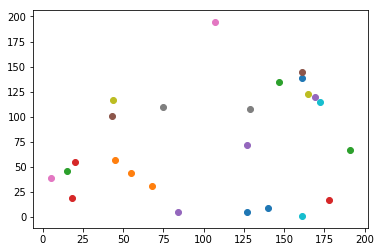

In [16]:
#Generate Random City Locations, Seed 42
cityList = []
random.seed(42)

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
    
#Plot Random City Locations Generated    
for i in cityList:
    plt.scatter(i.x, i.y)
    
plt.show()

2. Then, running the genetic algorithm is one simple line of code. This is where art meets science; you should see which assumptions work best for you. In this example, we have 100 individuals in each generation, keep 20 elite individuals, use a 1% mutation rate for a given gene, and run through 500 generations:

In [19]:
bestRoute = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)


Initial distance: 2036.2973778756273
Final distance: 766.4564300162858


*Note: Running __bestRoute__ does not always offer the same optimization. Different runs offer different solutions. 

The best solution so far that I have ran is __Final distance: 766.4564300162858__

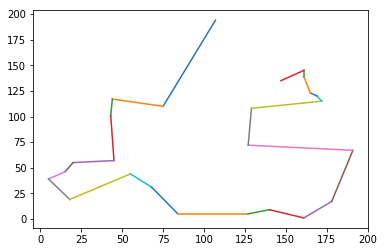

In [22]:
#Plot to show BestRoute
#Note: Completing the route from finish back to start is equivalent to the final distance above
x = []
y = []

for i in bestRoute:
    x.append(i.x)
    y.append(i.y)
    
    if len(x) == 2:
        plt.plot(x,y)
    elif len(x) > 2:
        x.pop(0)
        y.pop(0)
        plt.plot(x,y)
        
plt.show()


### Bonus feature: Plot the improvement

It’s great to know our starting and ending distance and the proposed route, but we would be remiss not to see how our distance improved over time. With a simple tweak to our __*geneticAlgorithm*__ function, we can store the shortest distance from each generation in a __*progress*__ list and then plot the results.


In [133]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the GenAlg in the same way as before, but now using the newly created __*geneticAlgorithmPlot*__ function:

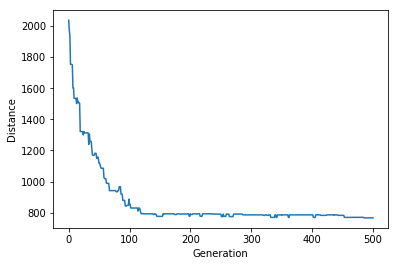

In [134]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)


### Conclusion

I hope this was a fun, hands-on way to learn how to build your own GA. Try it for yourself and see how short of a route you can get. Or go further and try to implement a GA on another problem set; see how you would change the __*breed*__ and __*mutate*__ functions to handle other types of chromosomes. We’re just scratching the surface here!